# The theoretically maximized expectation (oracle value)

From the table of $\theta_j$, we should always choose arm 1 since it has the greatest probability of winning, $0.8$, bigger than the others $0.6$ and $0.5$. In other words,$argmax([0.8, 0.6, 0.5]) = \mathrm{the\ first\ one}$. Therefore the theoretically maximized expectation of the aggregate rewards over $6000$ time slots is 

$$
    E(\sum_{t=1}^{N} r_{I(t)}) = \sum_{t=1}^{N} E(r_{I(t)}) = \sum_{t=1}^{N} \theta_{I(t)} = 6000\cdot 0.8=4800
$$

# Classical bandit algorithms' implementation

In this part, we use python to simulate these three algorithms. 

Each algorithms are simulated with real probability [0.8, 0.6, 0.5], and repeats for 200 times to get an average. During the process, the results' average and variance are calculated.

The code and result is as follows. (The first code block is the dependencies and real probability used by all the following codes.)

In [3]:
import numpy as npy
import scipy.stats as st
import matplotlib.pyplot as plt

N: int = 6001  # the number of time slots
realProb: npy.ndarray = npy.array([0.8, 0.6, 0.5])  # real probability of arms


## $\epsilon$-greedy algorithm simulation

In [4]:
def EpsilonGreedy(epsilon: float) -> int:
    sumOfResult: int = 0  # sum of rewards
    theta: npy.ndarray = npy.zeros(3)  # experienced (posterior) probability
    count: npy.ndarray = npy.zeros(3)  # pulling count for each arm
    # Generate an r.v. with Bern(epsilon) distribution
    option = npy.random.binomial(1, epsilon, N)
    for t in range(N):
        # exploitation and exploration trade-off
        if option[t] == 0: # exploitation 
            # choose the arm with currently known greatest probability 
            arm = npy.argmax(theta)      
        else:              # exploration
            # randomly choose an arm to explore new possibilities
            arm = npy.random.randint(3)  
        # pull the arm and get the result
        reward = npy.random.binomial(1, realProb[arm])
        sumOfResult += reward
        # update 'count' and 'posterior probability'
        count[arm] += 1
        theta[arm] += (reward - theta[arm]) / count[arm]
    # after the whole game, return the sum of rewards
    return sumOfResult

## UCB simulation

In [19]:
def UCB(c: int = 2):
    sumOfResult: int = 0  # sum of rewards
    theta = npy.zeros(3)  # experienced (posterior) probability
    count = npy.zeros(3)  # pulling count for each arm
    for arm in range(3):  # init when t = 1,2,3
        count[arm] = 1
        reward = npy.random.binomial(1, realProb[arm])
        sumOfResult += reward
        theta[arm] = float(reward)
    for t in range(3, N):  # proceed for t = 4 to N
        # calculate the traded-off value (of exploit. and explore.) of 3 arms
        temp_list = npy.array(theta + c * npy.sqrt(2 * npy.log(t+1) / count))
        arm = npy.argmax(temp_list)  # choose the best arm 
        reward = npy.random.binomial(1, realProb[arm])  # pull the arm
        sumOfResult += reward
        count[arm] += 1  # update 'count' and 'posterior probability'
        theta[arm] += ((reward - theta[arm]) / count[arm])
    return sumOfResult

## Thompson Sampling simulation

In [7]:
def ThompsonSampling(prior: list) -> int:
    sumOfResult: int = 0  # sum of rewards
    BetaVar: npy.ndarray = npy.array(prior)  # prior beta distribution parameters
    theta: npy.ndarray = npy.zeros(3)
    for t in range(N):
        for i in range(3):  # sample 'theta' from Beta distribution
            theta[i] = npy.random.beta(BetaVar[i][0], BetaVar[i][1])
        arm = npy.argmax(theta)
        # pull the arm and get the result
        reward = npy.random.binomial(1, realProb[arm])
        sumOfResult += reward
        # update beta distribution parameter
        BetaVar[arm][0] += reward
        BetaVar[arm][1] += (1 - reward)
    return sumOfResult

# Simulation of the three algorithms 

In this part, we simulate these algorthms with different parameters, and see the reward averaged over 200 tries.

## $\epsilon$-greedy algorithm simulation

When epsilon=0.2, average result is 4597.63, variance is 955.5630999999998
When epsilon=0.4, average result is 4396.005, variance is 1125.5549749999998
When epsilon=0.6, average result is 4201.525, variance is 1084.919375
When epsilon=0.8, average result is 4000.09, variance is 1426.6519


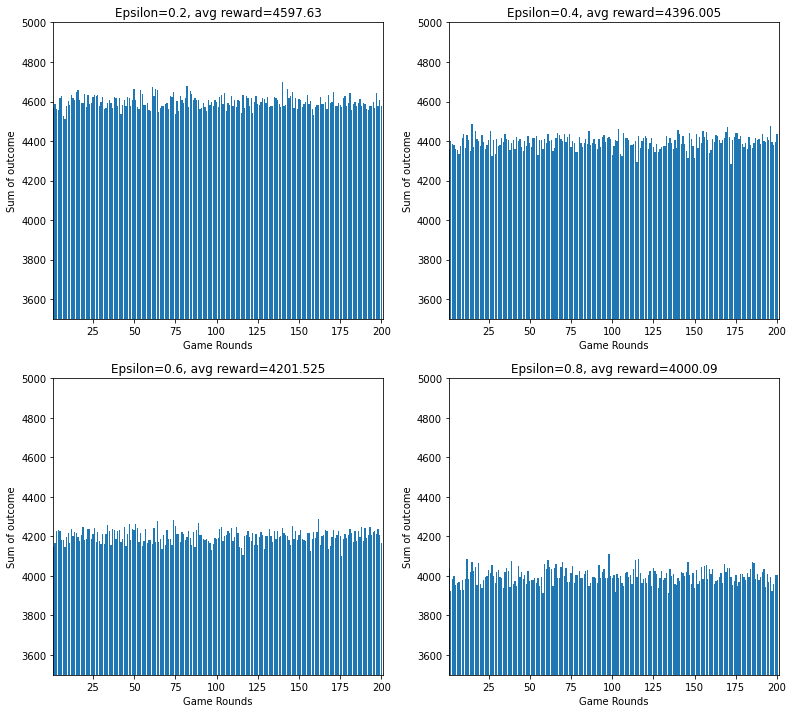

In [5]:
def RepeatEpsilon(Repeats=200) -> None:
    result = npy.zeros(Repeats)
    epsilon_list = [0.2, 0.4, 0.6, 0.8]  # try these epsilon values
    plt.figure(figsize=(13, 12))  # set the output figure size
    plt.title("Result with different epsilons")
    for k in range(len(epsilon_list)):
        ep = epsilon_list[k]
        for i in range(Repeats):  # repeat 200 times and store each result
            result[i] = EpsilonGreedy(epsilon=ep)
        avg: float = npy.average(result)  # calculate the averaged result
        # plot the results and see its average and variance
        plt.subplot(2, 2, k+1)
        plt.bar(npy.arange(1, len(result)+1, 1), result)
        plt.title("Epsilon={}, avg reward={}".format(ep, avg))
        plt.xlabel("Game Rounds");  plt.ylabel("Sum of outcome")
        plt.xlim(1, len(result)+1); plt.ylim(3500, 5000)
        print("When epsilon={}, average result is {}, variance is {}".format(ep, avg, npy.var(result)))
    plt.show()

if __name__ == '__main__':
    RepeatEpsilon(Repeats=200)


From the result, when $\epsilon=0.2$, the algorithm behaves best. As $\epsilon$ grows larger, the result tend to be worse.

## UCB algorithm simulation

When c=2, average result is 4548.465, variance is 1434.698775
When c=6, average result is 4144.035, variance is 1247.073775
When c=9, average result is 4029.43, variance is 1158.1851000000001


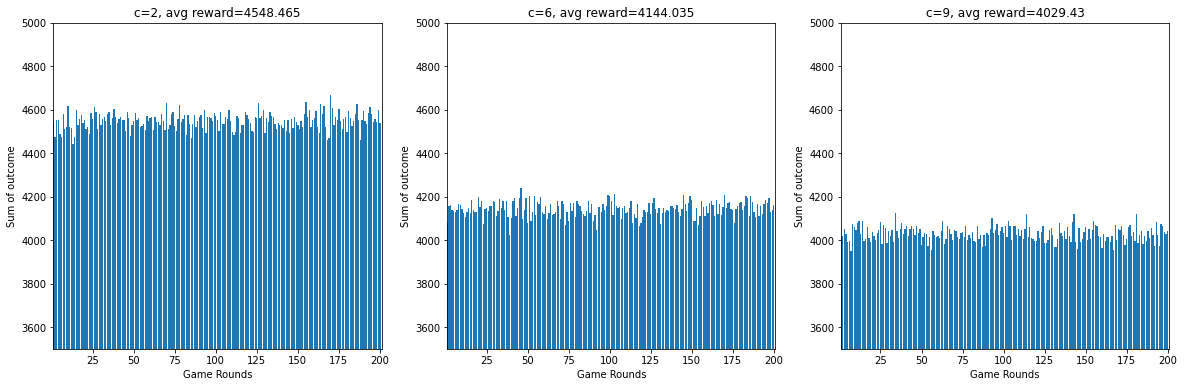

In [20]:
def RepeatUCB(Repeats=200) -> None:
    result = npy.zeros(Repeats)
    c_list = [2, 6, 9]
    plt.figure(figsize=(20, 6))  # set the output figure size
    for k in range(len(c_list)):
        cv = c_list[k]
        for i in range(Repeats):  # repeat 200 times and store each result
            result[i] = UCB(c=cv)
        avg: float = npy.average(result) # calculate the averaged result
        # plot the results and see its average and variance
        plt.subplot(1, 3, k+1)
        plt.bar(npy.arange(1, len(result)+1, 1), result)
        plt.title("c={}, avg reward={}".format(cv, avg))
        plt.xlabel("Game Rounds");  plt.ylabel("Sum of outcome")
        plt.xlim(1, len(result)+1); plt.ylim(3500, 5000)
        print("When c={}, average result is {}, variance is {}".format(cv, avg, npy.var(result)))
    plt.show()

if __name__ == '__main__':
    RepeatUCB(Repeats=200)

From the result, $c=2$ is the best choice among the simulated values.

## Thompson Sampling algorithm simulation

When prior=[[1, 1], [1, 1], [1, 1]], average result is 4785.165, variance is 1195.737775
When prior=[[601, 401], [401, 601], [2, 3]], average result is 4789.905, variance is 1112.645975


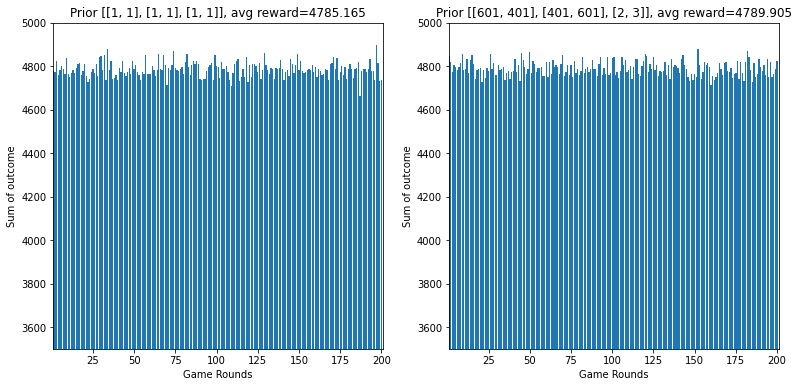

In [11]:
def RepeatTS(Repeats=200) -> None:
    result = npy.zeros(Repeats)
    beta_list = [[[1, 1], [1, 1], [1, 1]], [[601, 401], [401, 601], [2,3]]]
    plt.figure(figsize=(13, 6))
    for k in range(2):
        b = beta_list[k]
        for i in range(Repeats):
            result[i] = ThompsonSampling(prior=b)
        avg: float = npy.average(result)
        plt.subplot(1, 2, k+1)
        plt.bar(npy.arange(1, len(result)+1, 1), result)
        plt.title("Prior {}, avg reward={}".format(b, avg))
        plt.xlabel("Game Rounds");  plt.ylabel("Sum of outcome")
        plt.xlim(1, len(result)+1); plt.ylim(3500, 5000)
        print("When prior={}, average result is {}, variance is {}".format(b, avg, npy.var(result)))
    plt.show()

if __name__ == '__main__':
    RepeatTS(Repeats=200)


# Numerical results' comparison and parameters' impact

## Algorithm result comparison

### The gaps and variances of the algorithm outputs

As is described in Task 1, the oracle value is $6000\cdot 0.8=4800$. By using $$\mathrm{gap} = \mathrm{oracle\ value} - \mathrm{real\ value}$$ we can find the gap.

1. Epsilon-greedy algorithm 

| epsilon value | Average sum of reward | Variance    | Gap  |
| ------------- | --------------------- | ----------- | ---- |
| 0.2           | 4596.95               | 1079.58 |  203.05    |
| 0.4           | 4399.44               | 1344.98 |  400.56    |
| 0.6           | 4202.04               | 1356.96 |  597.56    |
| 0.8           | 3998.50               | 1196.28 |  801.5    |

2. UCB algorithm

| c value       | Average sum of reward | Variance    | Gap  |
| ------------- | --------------------- | ----------- | ---- |
| 2             | 4544.56               | 1338.49 |  255.44    |
| 6             | 4140.30             | 1032.85 |   659.7   |
| 9             | 4030.12              | 1227.88 |   769.88   |

3. Thompson Sampling algorithm

| prior distribution value         | Average sum of reward | Variance  | Gap  |
| -------------------------------- | --------------------- | --------- | ---- |
| [(1, 1), (1, 1), (1, 1)]         | 4786.01               | 1125.25 |   13.99   |
| [(601,401), (401,601), (2,3)]    | 4793.39               | 1147.53 |   6.61   |



### Analysis of the algorithm outputs

To judge an algorithm's goodness, we need to focus on both its accuracy and stability. Accuracy can be measured by the gap, and stability can be measured by its variance. A higher variance indicates poorer stability. 

- As for **accuracy**, clearly, Thompson Sampling behaves best in the three algoriths. Both prior beta distributions in the case turns out to be great. The final results are very close to 4800, the oracle value. To understand why it is best, we need some further analysis, described later.

- As for **stability**, epsilon-greedy algorithm with $\epsilon=0.2$, and Thompson sampling algorithm with both cases performs better, whose variances are around $1000$, evidently lower than epsilon-greedy algorithm with larger $\epsilon$, and UCB algorithm. For $\epsilon$-greedy, this meets our intuitive, since larger $\epsilon$ means higher probability of exploration (which has more uncertainty, increasing variance).

Therefore, given the above table and considering both accuracy and stability, Thompson sampling algorithm is the best among the three algorithms.

## The parameters' impacts

To see the parameters' ($\epsilon, c$ and prior beta distribution), we can first try more parameters ($\epsilon$, $c$, or prior beta distribution) in the algorithms in order to try to find the best parameter value. This helps we understand the impacts of the parameters respectively.

**Note**: Since the impact of the parameters is highly correlated with the exploration-exploitation trade-off, **such impact of the parameters will be discussed in detail in next part**, `the understanding of exploration-exploitation trade-off'. 
Setting them apart is complicated and might harm the logicality as well as readibility. 

### Epsilon-greedy algorithm 

For epsilon-greedy algorithm, after trying several $epsilon$ (each repeat for 200 times to get an average), we can draw the graph showing the relationship of epsilon and final result. The code and result is as follows:

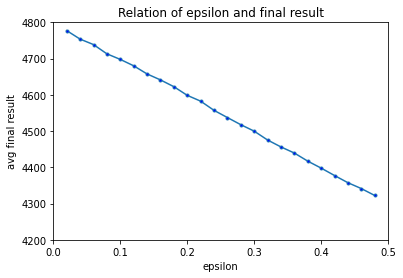

In [5]:
def PlotEpsilon(Repeats: int=200):
    # create a list of [0.02, 0.04, ..., 0.5] to store epsilon and result
    epsilon_list = npy.arange(0.02, 0.5, 0.02)
    result_list  = npy.arange(0.02, 0.5, 0.02)
    for i in range(24):
        ep = epsilon_list[i]
        sumR = 0
        # for each epsilon, repeat for 200 times to get an averaged output
        for j in range(Repeats):  sumR += EpsilonGreedy(epsilon=ep)
        result_list[i] = sumR / Repeats
        # this line is for debug use
        # print("epsilon={}, avg={}".format(ep, result_list[i]))
    # Plot the relationship between epsilon and final result
    plt.subplot(111)
    plt.title('Relation of epsilon and final result')
    plt.plot(epsilon_list, result_list, marker='o', markerfacecolor='blue', markersize=3)
    plt.xlim(0, 0.5);       
    plt.ylim(4200, 4800)
    plt.xlabel("epsilon");  
    plt.ylabel("avg final result")
    plt.show()

if __name__ == '__main__':
    PlotEpsilon()

The result seems inconsistent with our intuitive guess that, $\epsilon=0$ makes the greatest result. We know that a small epsilon value means higher probability of 'expoitation', but why does pure exploitation behaves best? It's because that `numpy.argmax(arr)` will always return the first max value's index if there are several equal max values. For example, the following code 

`numpy.argmax(arr)  # arr = [0, 0, 0]`

will always return $0$, instead of a random value of $0, 1, 2$. In a coincidence, the first arm turns out to be the arm with greatest probability (which is $0.8$, compared with $0.6$ and $0.5$). By pure exploitation, the algorithm selects the first arm every time, letting the final result be greatest (very close to oracle value $4800$).

To make the result more general, we can rewrite the above function, letting `argmax` return a random number between the indexes if equal values exists. The real probability and the oracle value are unchanged in the new case. The corrected code and result is as follows:

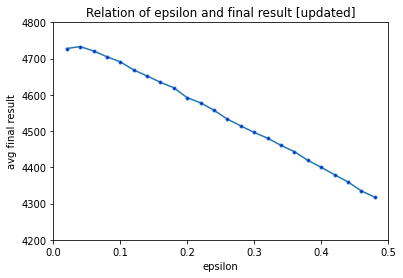

In [6]:
'''rewritten function of argmax(theta) '''
'''which returns a random number between indexes when same values exists'''
'''e.g. argmax3([0,0,0]) will return a random number of 0,1,2 instead of 0'''
def argmax3(theta: npy.ndarray):
    if theta[0] == theta[1] == theta[2]:
        return npy.random.randint(3)
    elif theta[0] == theta[1] and theta[0] > theta[2]:
        return (0 if npy.random.binomial(1, 0.5) else 1)
    elif theta[1] == theta[2] and theta[1] > theta[0]:
        return (1 if npy.random.binomial(1, 0.5) else 2)
    elif theta[0] == theta[2] and theta[0] > theta[1]:
        return (0 if npy.random.binomial(1, 0.5) else 2)
    else:
        return npy.argmax(theta)

'''Modified EpsilonGreedy function which uses the above 'argmax' function instead of the method in numpy'''
def EpsilonGreedy(epsilon: float = 0.2) -> int:
    sumOfResult: int = 0  # sum of rewards
    theta = npy.zeros(3)  # experienced (posterior) probability
    count = npy.zeros(3)  # pulling count for each arm
    # Generate an r.v. with Bern(epsilon) distribution
    option = npy.random.binomial(1, epsilon, N)
    for t in range(N):
        # exploitation and exploration trade-off
        if option[t] == 0: # exploitation 
            # choose the arm with currently known greatest probability 
            # arm = npy.argmax(theta)   
            arm = argmax3(theta)   
        else:              # exploration
            # randomly choose an arm to explore new possibilities
            arm = npy.random.randint(3)  
        # pull the arm and get the result
        reward = npy.random.binomial(1, realProb[arm])
        sumOfResult += reward
        # update 'count' and 'posterior probability'
        count[arm] += 1
        theta[arm] += (reward - theta[arm]) / count[arm]
    # after the whole game, return the sum of rewards
    return sumOfResult

def PlotEpsilon(Repeats: int=200):
    epsilon_list = npy.arange(0.02, 0.5, 0.02)
    result_list  = npy.arange(0.02, 0.5, 0.02)
    for i in range(24):
        ep = epsilon_list[i]
        sumR = 0
        for j in range(Repeats):  sumR += EpsilonGreedy(epsilon=ep)
        result_list[i] = sumR / Repeats
        # print("epsilon={}, avg={}".format(ep, result_list[i]))
    plt.subplot(111)
    plt.title('Relation of epsilon and final result [updated]')
    plt.plot(epsilon_list, result_list, marker='o', markerfacecolor='blue', markersize=3)
    plt.xlim(0, 0.5);       plt.ylim(4200, 4800)
    plt.xlabel("epsilon");  plt.ylabel("avg final result")
    plt.show()

if __name__ == '__main__':
    PlotEpsilon()

In this time, we find that $\epsilon\approx 0.04$ behaves best.


### UCB algorithm analysis

Similar for the UCB algorithm. A smaller $c$ means higher probability of exploitation. We can draw the graph showing the relationship of $c$ and final result (the same correction on 'numpy.argmax()' is also implemented). The code and result is as follows:

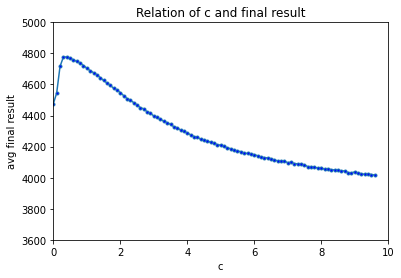

In [21]:
def PlotC(Repeats: int=200):
    c_list      = npy.arange(0, 10, 0.1)
    result_list = npy.arange(0, 10, 0.1)
    for i in range(97):
        cv = c_list[i]
        sumR = 0
        for j in range(200):  sumR += UCB(c=cv)
        result_list[i] = sumR / Repeats
        # this line is for debug use only.
        # print("c={}, avg={}".format(cv, result_list[i]), end=' ; ')

    plt.subplot(111)
    plt.title('Relation of c and final result')
    plt.plot(c_list, result_list, marker='o', markerfacecolor='blue', markersize=3)
    plt.xlim(0, 10);  plt.ylim(3000, 5000)
    plt.xlabel("c");  plt.ylabel("avg final result")
    plt.show()

if __name__ == '__main__':
    PlotC()

From the graph above, the algorithm behaves best when $c\approx 0.035$.

### Thompson Sampling algorithm analysis

For the Thompson-Sampling Problem, we can find that it works perfect, much better than the above two algorithms, as its output is very close to `4800`. The reason why it works well will be described in detail in task 5 (the understanding of exploration-exploitation trade-off). 


# Understanding of the exploration-exploitation trade-off.

## $\epsilon$-greedy algorithm

In $\epsilon$-greedy, the exploration-exploitation trade-off is used apparently in its theory. It selects an arm with best known probability (exploitation) or randomly select an arm (exploration) with probability in relation to the parameter $\epsilon$. The parameter $\epsilon$ controls the trade-off. Lower $\epsilon$ means higher tendency for exploration, and vice versa. 

By the graph of the relationship between epsilon and final result, we know that there is a greatest value $\epsilon_0$ which maximizes the expected reward, and other $\epsilon$ lower or bigger than it gives worse outcome. 

- When $\epsilon = 0$, the tradeoff is downgraded to pure exploitation. Initially, all arms have $\hat{\theta_j} = 0$, so it randomly selects an arm. After the first nonzero outcome is observed, the corresponding arm's $\hat{\theta_j}$ will grow to a positive value. Since there's only exploitation is used, this arm will be selected for all of the rest playtimes. 

- When $0 < \epsilon < 1$, exploration process has increased probability. Instead of selecting the first-nonzero-reward-arm (above), the exploration can observe a more accurate estimated probability, thus increasing the probability that the best arm be selected. Therefore, as $\epsilon$ increases in this interval, the final reward also increases.

- When $\epsilon = \epsilon_0$, the algorithm reaches its peak. 

- When $\epsilon_0 < \epsilon < 1$, the reward goes down, since too much exploration may waste chances on random selected arms, although we have already gain enough knowledge on the estimated probability and can directly use exploitation. That's why as $\epsilon$ increases, the result tends to decrease. 

- When $\epsilon = 1$, the trade-off is now pure exploration, which means we randomly choose an arm all the times. The estimated probability got no use here. In this case, the estimated final result is close to $\frac{1}{3} \cdot (0.8+0.6+0.5) \cdot 6000 = 3800$. 

In conclusion, the algorithm balances exploration and exploitation through with given probabilities $\epsilon$ and $1- \epsilon$. This is a simple, but only a binary opposition trade-off. 

## UCB algorithm 

In Upper Confidence Bound, or UCB algorithm, it uses some tricks to balance exploration and exploitation. It first tests each arm for one time, and then calculate the score of three arms and chooses the best by the following formula 

$$
    \hat{\theta_j} + c\cdot \sqrt{\frac{2\cdot \log t}{count(j)}}
$$

where $\hat{\theta_j}$ is the average reward obtained from arm $j$ (similar to sample mean's definition), and the latter $\sqrt{\frac{2\cdot \log t}{count(j)}}$ represents the standard deviation, indicating the length of the confidence interval. $t$ is the current time played, and $count(j)$ is the number of arm $j$ pulled so far. 

In detail, the exploration-exploitation tradeoff happens in the follow way:

- If an arm is pulled for few times, $\sqrt{\frac{2\cdot \log t}{count(j)}}$ tends to be higher since the confidence interval is larger, and it will be more likely to be selected more times. This is exploitation. As the time of sampling increases, the confidence interval gets shorter, and we are getting sure about the arms' probability, therefore the arm with greatest probability will be selected more times. This is exploration.

- The paramter $c$ controls the importance of exploitation. A higher $c$ indicates larger weight of uncertainty, while a lower $c$ means a larger weight on exploitation. 

UCB algorithm should behave better than $\epsilon$-greedy, since it judges the confidence intervals' upper bound to choose arm, instead of choosing with a fixed probability.


Additionally, we find that both $\epsilon$-greedy and UCB reaches best performance with a relatively small parameter ($\epsilon\approx 0.04$ or $c\approx 0.035$), or, very high tendency of exploitation. This is because that, after enough tries, we are confident about the probability under three arms, and we have find the first arm has greatest probability (with a very high probability). Therefore a parameter near pure exploitation behaves best.

Thinking about how to optimize the algorithms. Can we tend more to exploration at the beginning, and then 'switches' to exploitation after we are sure about the arms? This is similar to the core of Thompson Sampling algorithm.

## Thompson Sampling algorithm

In Thompson Sampling algorithm, the trade-off lies in another, and much better way. To better visualize the process, we plot the beta distribution's PDF and see how it changes over time, and try different combinations of prior beta distributions $\mathrm{Beta}(\alpha, \beta)$.

### Different case examples 

#### Case 1: $\mathrm{Beta}(1,1)$ for all three arms 

Consider a prior beta distribution of $\mathrm{Beta}(1,1)$ for all the three arms, and plot the beta distribution's PDF from time to time. The code and result is as follows:

The final rewards gotten is 4801


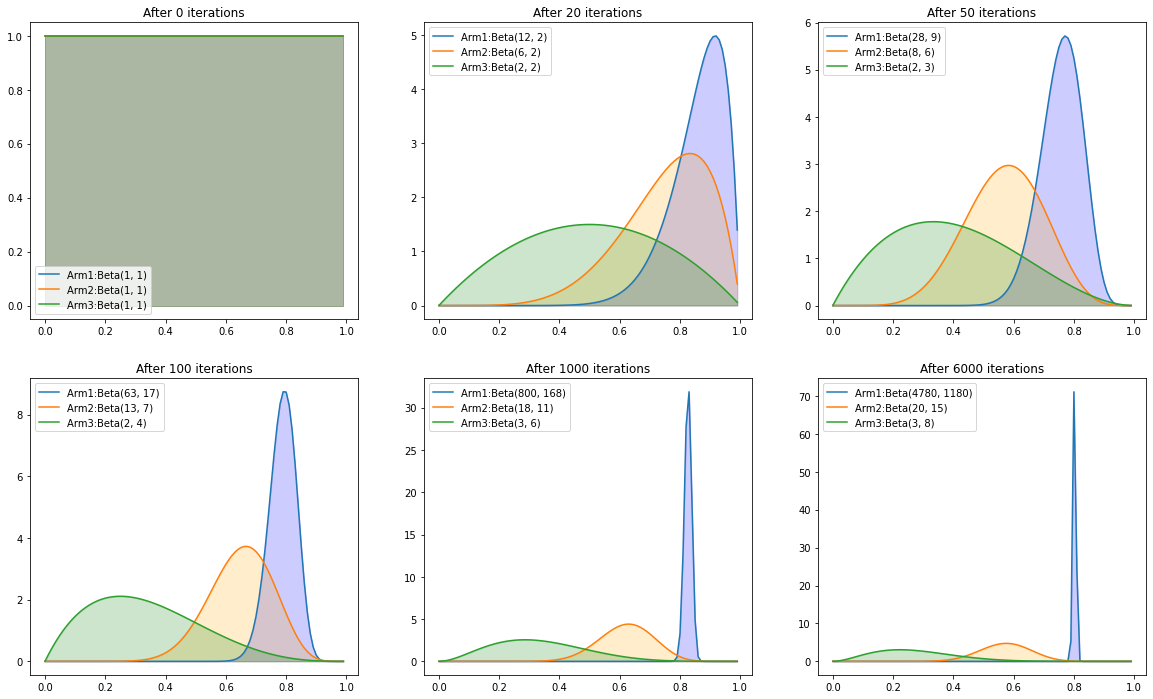

In [14]:
PlotBetaTimes: list = [0, 20, 50, 100, 1000, 6000]
colorBase: list = ['b', 'orange', 'g']

def plotBetaByTheta(param: npy.ndarray, t: int):
    plt.title("After {} iterations".format(t))
    x: npy.ndarray = npy.arange(0, 1, 0.01)
    for i in range(0, 3):
        y: npy.ndarray = st.beta(param[i][0], param[i][1]).pdf(x)
        # plot the PDF curve
        plt.plot(x, y, label=r'Arm%d:Beta(%d, %d)' % (i+1, param[i][0], param[i][1]))
        # color the area under the curve
        plt.fill_between(x, 0, y, color=colorBase[i], alpha=0.2)
        plt.legend()

def TS_and_PlotBeta(prior: list) -> int:
    sumOfResult: int = 0  # sum of rewards
    BetaVar: npy.ndarray = npy.array(prior)  # prior beta distribution parameters
    theta: npy.ndarray = npy.zeros(3)
    k = 0
    for t in range(N):
        # plot representative current Beta distribution 
        if t in PlotBetaTimes:
            plt.subplot(2, 3, k+1)
            plotBetaByTheta(BetaVar, t)
            k+=1
        # main TS algorithm 
        for i in range(3):  # sample 'theta' from Beta distribution
            theta[i] = npy.random.beta(BetaVar[i][0], BetaVar[i][1])
        arm = npy.argmax(theta)
        # pull the arm and get the result
        reward = npy.random.binomial(1, realProb[arm])
        sumOfResult += reward
        # update beta distribution parameter
        BetaVar[arm][0] += reward
        BetaVar[arm][1] += (1 - reward)
    print("The final rewards gotten is {}".format(sumOfResult))
    return sumOfResult

if __name__ == '__main__':
    plt.figure(figsize=(20, 12))
    TS_and_PlotBeta(prior=[[1, 1], [1, 1], [1, 1]])
    plt.show()


(Explanation of the graph above: This graph contains the PDF of the beta distribution of the 3 arms at different time. The blue, orange, and green line representes the curve of arm 1,2,3's beta distribution respectively. The text shows the beta distribution parameters.)

We know that a random variable $X\sim \mathrm{Beta}(\alpha,\beta)$ has expectation $E(X) = \frac{\alpha}{\alpha + \beta}$ and variance $Var(X) = \frac{\alpha\beta}{(\alpha + \beta)^2(\alpha + \beta+1)}$. As the game continues, both $a$ and $b$ will grow larger, and the variance will get lower. 

Taking the blue line (the PDF curve of the first arm beta distribution) as an example. When there's only a few tries, the beta distribution has a larger variance, and the beta distribution PDF looks smooth. As the game continues, the beta distribution tends to be low in variance, and the curve tends to be slender and slender. At the same time, the beta distribution's expectation as well as the peak of the beta distribution converges to $0.8$, the real probability of this arm.

An exploration-exploitation trade-off lies under the above process. By the pseudocode, the choice comes from the sampled value of the beta distribution. 

- At the beginning, since all the beta distribution have a large variance, there's a lot of uncertainty when sampling from the beta distribution, which is like the exploration process. At the same time, since we are not so sure about the estimation of real probabilities, such exploration is important. 

- As the games proceeds, the beta distributions' variance decreases and also converges to the real probability, the arm with highest probability will be more and more likely to be chosen. This can avoid useless exploration, as we are already very sure about the real probabilities. 

This exploration-exploitation trade-off is totally different from previous two trade-offs, the one in epsilon greedy and UCB. It tends to explore at first, and gradually switches to exploit after there are less uncertainty on estimated probabilities. This process not only make sure the correct arm will be selected for the most time, elimating the useless chances spent on exploration, but also gain data from real distributions which is more accurate than estimation. That's the reason accounts for its goodness.

Then let's see another example below.

#### Case 2: prior distribution $\mathrm{Beta}(601, 401), \mathrm{Beta}(401, 601), \mathrm{Beta}(2,3)$

The final rewards gotten is 4760


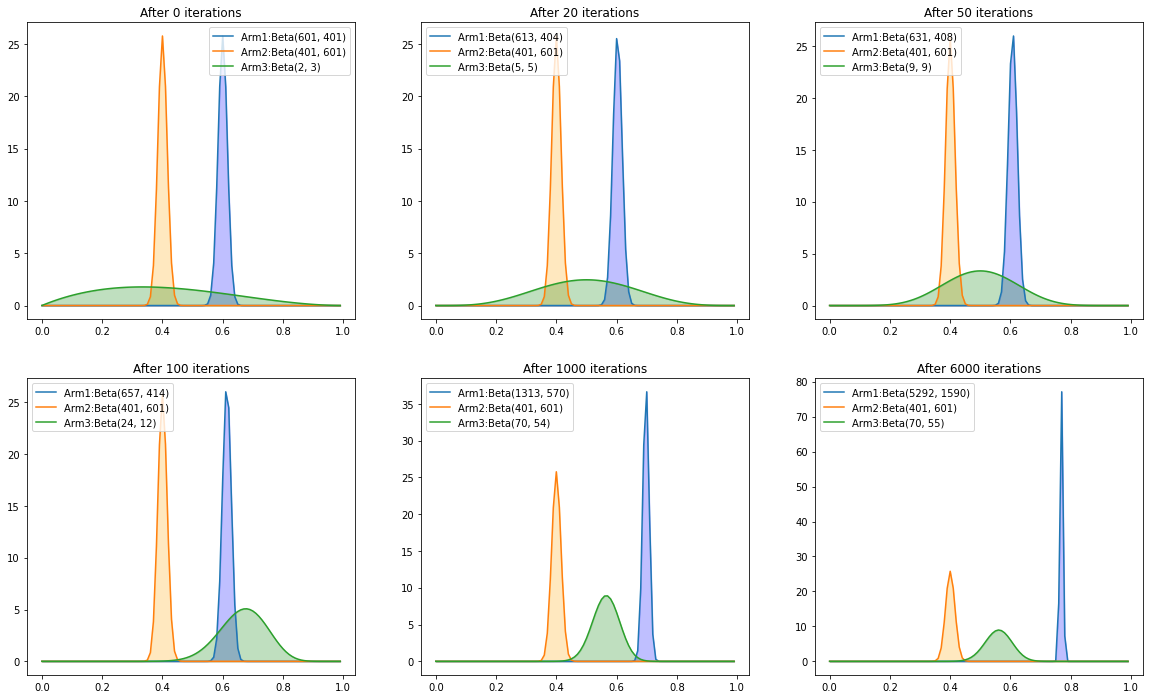

In [66]:
if __name__ == '__main__':
    plt.figure(figsize=(20, 12))
    TS_and_PlotBeta(prior=[[601, 401], [401, 601], [2,3]])
    plt.show()

From the graph, the blue line (arm 1) has prior expectation close to $0.6$, and it gradually moves towards $0.8$, the real probability. The orange line almost does not change at all, since both the blue line and the orange line are low in variance, and the former one often samples higher. 

The final result is also close to 4800, the oracle value, as arm 1 is still chosen for the most of the time.

#### Case 3: prior distribution $\mathrm{Beta}(801, 201), \mathrm{Beta}(601, 401), \mathrm{Beta}(501, 501)$

The final rewards gotten is 4803


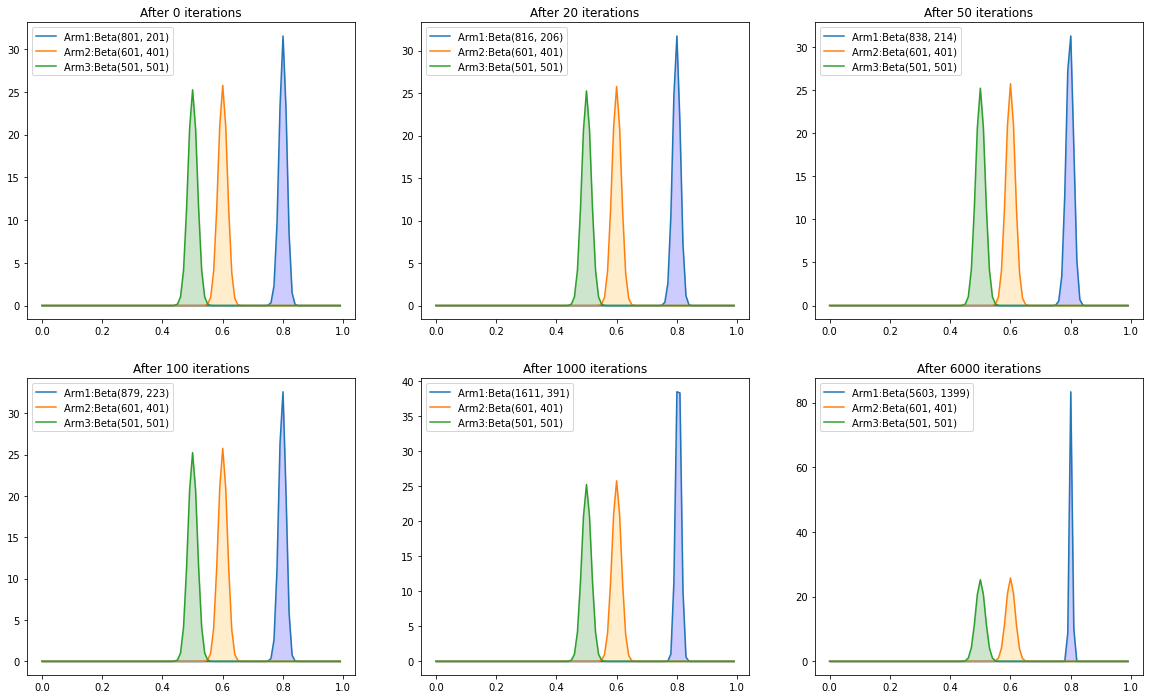

In [17]:
if __name__ == '__main__':
    plt.figure(figsize=(20, 12))
    TS_and_PlotBeta(prior=[[801, 201], [601, 401], [501, 501]])
    plt.show()

This is a best case, since the prior beta distribution just matches the correct probability. Note that arm 2 and 3's beta distribution does not changed at all, which means arm 1 is being selected all the time. 

#### Case 4: prior distribution $\mathrm{Beta}(401, 601), \mathrm{Beta}(601, 401), \mathrm{Beta}(2,3)$




The final rewards gotten is 3639


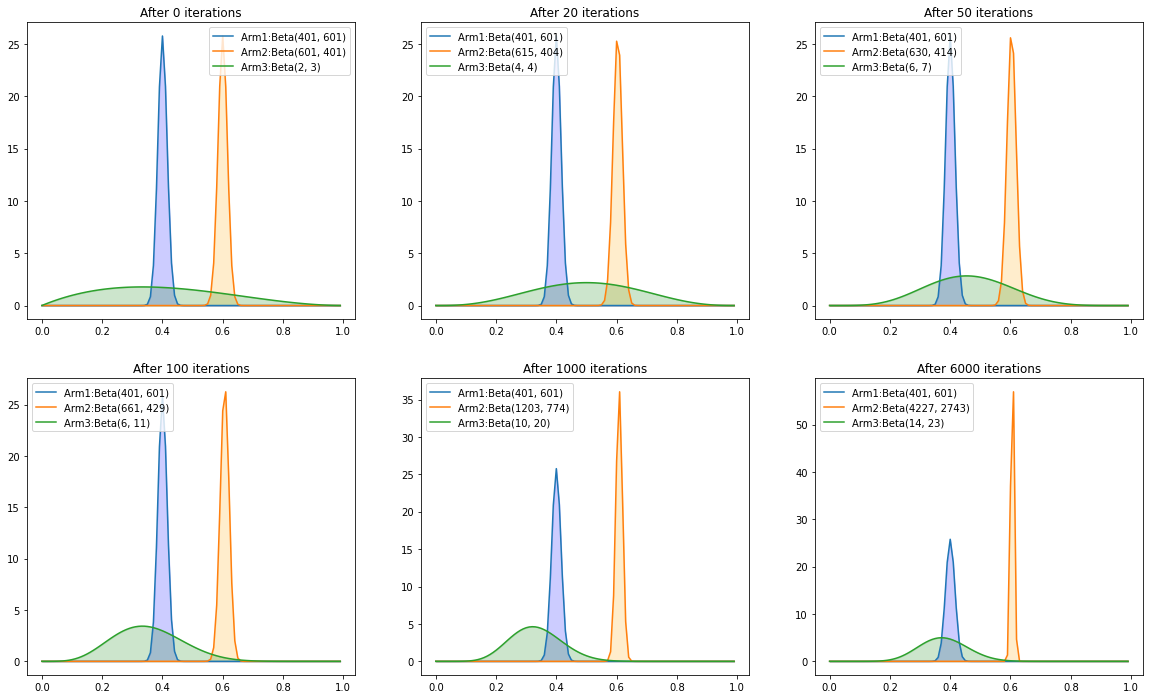

In [15]:
if __name__ == '__main__':
    plt.figure(figsize=(20, 12))
    TS_and_PlotBeta(prior=[[401, 601], [601, 401], [2, 3]])
    plt.show()

This time, the given beta distribution is 'misleading', and the algorithm does not behave so well. From the plotted graph, in this case, the algorithm chooses arm 2 for many times, ignoring arm 1 because they have all being pulled for 1000 times prior and it turns out that arm 2 is better. Arm 1 have a low chance to be corrected, since it is unlikely to be pulled under this circumstance.

#### Case 5: prior distribution $\mathrm{Beta}(361, 631), \mathrm{Beta}(401, 601), \mathrm{Beta}(201, 801)$


The final rewards gotten is 3565


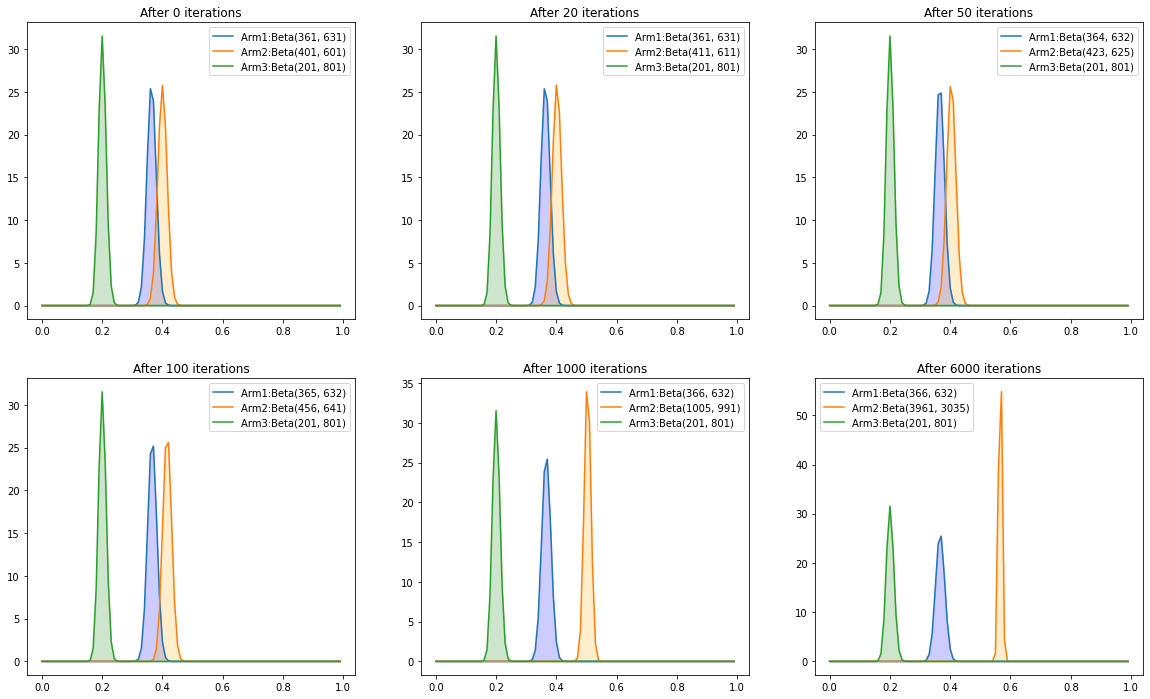

In [16]:
if __name__ == '__main__':
    plt.figure(figsize=(20, 12))
    TS_and_PlotBeta(prior=[[361, 631], [401, 601], [201, 801]])
    plt.show()

The algorithm's output $3565$ is still not so good (far from $4800$).As the playing time increases, the orange line (arm 2, with real probability $0.6$) moves gradually from the wrong position ($\approx 0.4$) to the correct position ($\approx 0.6$). Unluckily, too much emphasis has been put on this line instead of the blue line (arm 1). Arm 1's PDF nearly has not been corrected at all. As a result, the final result is also far from $4800$.

Now we can conclude the impacts of parameters $\alpha$ and $\beta$.

### Conclusion

Then let's discuss the **impacts of $\alpha$ and $\beta$**. 

- When both $\alpha$ and $\beta$ are very small, like the first example ($\mathrm{Beta}(1,1)$ for all three arms), all beta distributions have relatively large variance, which means they have similar probabilities to be selected, which is 'exploration' process. After some iterations, the best arm should be observed accurately, and the final results will be good, except for some exploration chances wasted at the beginning.

- When both $\alpha$ and $\beta$ are large, like the third example, the final result matters. Since the variances are relatively small, much weight will be put on exploitation, therefore the final result will depend highly on the given prior distribution. 

    - If the arm with maximum probability is indeed the arm with best prior distribution expectation, this algorithm perfroms extremely well, since the best arm will be pulled for nearly all the time. Like case 3 ($\mathrm{Beta}(801, 201), \mathrm{Beta}(601, 401), \mathrm{Beta}(501, 501)$), the final result sometimes can even exceed the oracle value $4800$!

    - However, if the given probability is 'misleading', that is , the arm with maximum probability isn't the arm with best prior beta distribution, then the algorithm does not perform so well. The algorithm will select the non-optimal arm (the one with best prior beta distribution expectation) instead of the optimal arm for nearly all the time, the final result is far from $4800$. Despite the beta distribution will be corrected, at least partially corrected, this does not help so much because $\alpha$ and $\beta$ are too big for this to happen. Consider the case 5, the beta distribution of arm 1 is moving from the wrong expectation ($\approx 0.4$) to the correct position $0.8$, it moves much slower than arm $2$, letting arm 2 be selected for the most time.

- When one of $\alpha, \beta$ is large and the other is small, the result is also highly depends on the prior probability, like the above ($\alpha, \beta$ are both large). In general, if an arm whose sum of prior beta distribution parameters, $\alpha+\beta$, is large and the expectation $\frac{\alpha}{\alpha+\beta}$ is small, then this arm is likely to be ignored for almost all of the time. If this arm is the non-optimal arm, the final result might still be good enough, but if this arm is the best arm, the final result might not be perfect, as it wrongly selects the not-best arm.

In one word, the beta distribution method tend to 'explore' at the beginning, and tend to 'exploit' after enough simulations. That's the reason for its excellence, but also the reason for its failure under specific given parameters. 

In real practice, thompson sampling has another advantage that, only use prior beta distributions $\mathrm{Beta}(1,1)$ is already good enough. Considering the fact that choosing bigger $\alpha$ and $\beta$ may either make it a bit better, or make it significantly worse, $\mathrm{Beta}(1,1)$ is a good solution concerning both accuracy and stability. In contrast, both epsilon-greedy and UCB algorithm requires a careful selection of the parameter $\epsilon$ or $c$, for a bad parameter might make the algorithm bahave significantly worse. 

# Dependent-arm case

We implicitly assume the reward distribution of three arms are independent. How about the dependent case? 

## Problem description

Like the basic setting, consider a time-slotted bandit system with several arms. Pulling each arm $j$ will obtain a reward satisfying Bernoulli distribution, independently. The parameters of the Bernoulli distribution are constant but unknown to us. However, it is given that the difference value of some arms are no larger than some value. This means gaining the knowledge of an arm may help us estimate another arm. Then how can we find the optimal policy to play the game?

Consider this detailed example settings:

- There are 3 arms. $N = 6000$.

- The reward of arm $j$ satisfies $\mathrm{Bern}(\theta_j)$ for $j = 1,2,3$. $\theta_j$ is fixed but unknown.

- We know that the difference gap between arm 2 and arm 3 is less than $0.1$, or in other words, $\lvert \theta_2 - \theta_3 \rvert \leq 0.1$.

## Main idea and algorithm design 

We can still apply the original algorithm, UCB or Thompson sampling, to this settings. But we might waste some tries on exploring, since knowing arm 2 can help us estimate arm 3. For example, if we found arm 2 has a poor probability, we can ignore arm 3 as well since it is sure to have a poor outcome as well. 
 
To improve it, we can **group arm 2 and arm 3 into a cluster** and view them together. This includes calculating the 'joint' probability. If we choose cluster 1, with only arm 1 in it, directly pull arm 1. If we choose cluster 2 with two possible subchoices arm 2 and arm 3, then we compare their estimated probabilities separately and decide.

Consider modifying the UCB algorithm. Besides $\theta_j$ recording the estimated probability of each arm, we need another $\phi_g$ to record the estimated probability of each cluster. Similarly, we need $groupCount(g)$ besides $armCount(j)$ to store both the count of arms and that of clusters. 

The pseudocode of both the general case and the detailed case are as follows:

**Pseudocode in LaTeX**

We can also use a modifies Thompson sampling algorithm for this dependent-case. Similar to the modified $\mathrm{UCB-Cluster}$ above, we measure the distribution of probabilities of clusters, as well as inside each clusters. 

# Constrainted case

We implicitly assume there are no constraints when pulling arms. For example, pull each arm will generate some cost and there are some bounds on such cost. Can you design an algorithm for constrained bandit learning problem?

## Problem description

Like the basic setting, we consider a time-slotted bandit system with three arms. Pulling each arm $j$ will obtain a reward satisfying Bernoulli distribution. However, in this problem, there's a major difference: you are given a number of budget, and you need to pay some money for pulling each arm. The money you need to pay is known to you, but the real probability $\theta_j$ is still unknown to you. The type of money you pay is different from the type of the reward. 

How to find the optimal policy to play the game which the expectation of aggregated reward is maximized?

Consider this detailed settings: 

- Your budget is $5000$
- Parameters $\theta_j$ are still $0.8, 0.6, 0.5$ for arm $1,2,3$ respectively.
- You need to pay $c_j = 3, 2, 1$ for pulling the arm $1,2,3$ respectively.

## Main idea and algorithm

### Oracle perspective 

Suppose we can obtain the Bernoulli parameters from an oracle. Then, in order to maximize the reward, simply pulling the arm with greatest ratio ($\theta_j / c_j$), the expectation of reward divided by the cost need to pay). In this setting, pulling arm 3 all the times gives the best outcome.

### Modified bandit algorithm

#### 1. UCB algorithm

We can still use the original UCB algorithm to find the arm with greatest probability $\theta$, except that we need to take the cost into account. The modified UCB algorithm uses 

$$
    I(t) = \arg\max_{j\in \{1,2,3\}} \left( \frac{\hat{\theta_j}}{c_j} + c\cdot \sqrt{\frac{2\log t}{\mathrm{count}(j)}} \right)
$$

to choose an arm every time. 

The whole pseudocode is as follows:

#### 2. Modified Thompson Sampling Algorithm

Recall that Thompson Sampling algorithm performs better than UCB generally, given that it only needs prior beta distribution $\mathrm{Beta}(1,1)$. We can still use this to estimate the probabilities under each arm, but use the ratio (instead of the estimated $\hat{\theta_j}$) to decide our choice every time. 

